# Segment images

The purpose of this notebook is to show how SAM (Segment anything) model (https://github.com/facebookresearch/segment-anything) can be used to segment images.

In [1]:
# import libraries

In [2]:
import torch
import os
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
import matplotlib.pyplot as plt
import matplotlib

ModuleNotFoundError: No module named 'segment_anything'

In [3]:
# for notebook plotting

In [4]:
%matplotlib inline

In [5]:
# checkpoint for the model can be downloaded from https://github.com/facebookresearch/segment-anything#model-checkpoints

In [2]:
# define model, checkpoint and input image
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_ABS_PATH = r"checkpoint\sam_vit_h_4b8939.pth"

NameError: name 'torch' is not defined

In [3]:
IMAGE_PATH = r"images\flower_small.jpg"

In [10]:
# load model
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_ABS_PATH)
sam.to(device=DEVICE)

mask_generator = SamAutomaticMaskGenerator(sam)

image_bgr = cv2.imread(IMAGE_PATH)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

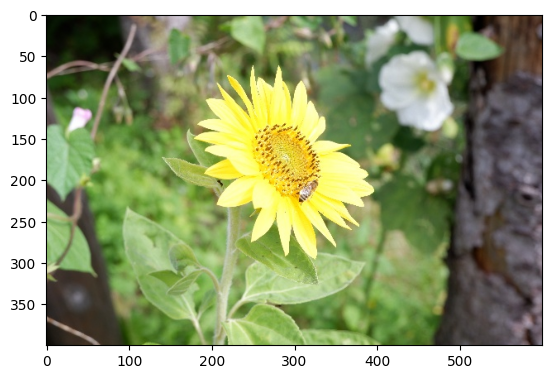

In [11]:
# disp input image
plt.imshow(image_rgb)

In [12]:
# generate segmentation mask, this step can be slow
masks = mask_generator.generate(image_rgb)

In [13]:
#available fields for each mask
masks[0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

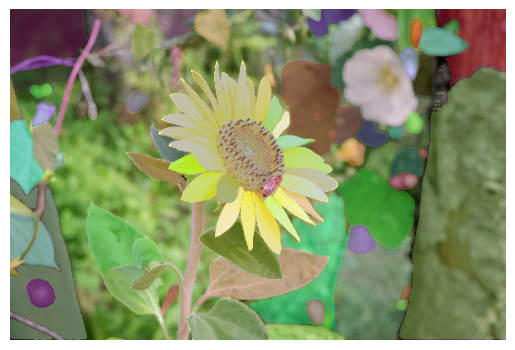

In [14]:
# helper function to show masks
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Note. dim 4 is for alpha channel
    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)
    
plt.imshow(image_rgb)
ax = plt.gca()
show_anns(masks)
plt.axis("off")
plt.show()

In [15]:
# show all segmented masks

In [16]:
# number of features detected
print("Number of masks:", len(masks))

Number of masks: 113


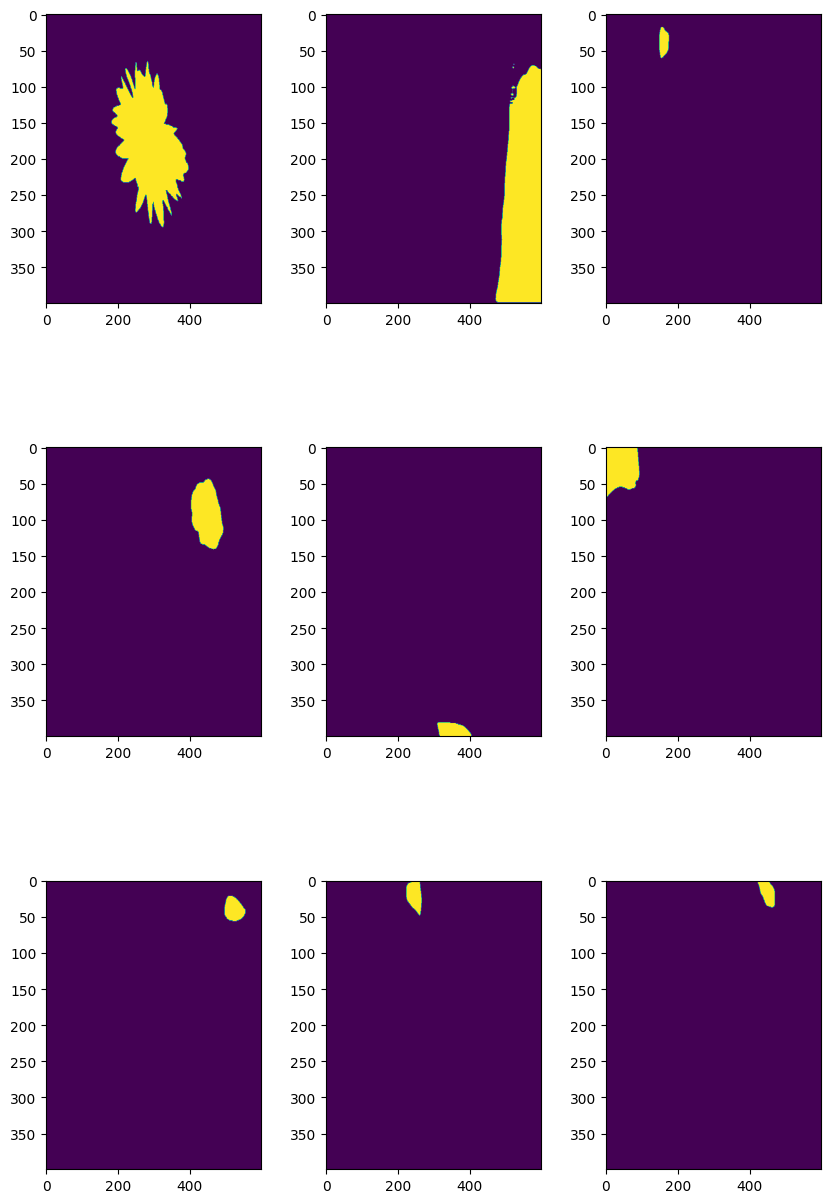

In [17]:
# let's displqy only some of them
NB_MASKS = 3 # number of rows
fig, axs = plt.subplots(NB_MASKS, 3, figsize=(10, 15), gridspec_kw={'wspace': 0.3, 'hspace': 0.5})

count = 0
for ax in axs.flat:
    ax.imshow(masks[count]['segmentation'], aspect='auto')
    count += 1

# Bounding box

We can also draw a bound box near the objects we want to segment and pass them to the model to improve the results. 

To draw the bounding box we will use a widget

In [4]:
#!pip install jupyter_bbox_widget

In [9]:
from jupyter_bbox_widget import BBoxWidget

In [14]:
widget = BBoxWidget(
    image=IMAGE_PATH,
    classes=['flower', 'bee'],
)
widget

BBoxWidget(classes=['flower', 'bee'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b'…

In [15]:
widget.bboxes

[{'x': 172, 'y': 52, 'width': 246, 'height': 252, 'label': 'flower'},
 {'x': 298, 'y': 191, 'width': 40, 'height': 42, 'label': 'bee'}]

In [25]:
box = widget.bboxes[1]
box = np.array([box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']])

In [26]:
predictor = SamPredictor(sam)
predictor.set_image(image_rgb)

In [27]:
masks, scores, logits = predictor.predict(box=box, multimask_output=True)

In [28]:
def plot_mask(masks):
    masks = np.moveaxis(masks, [0, 1, 2], [2, 0, 1])
    masks = masks[:,:,0]
    img = np.ones((masks.shape[0], masks.shape[1], 4))
    img[:,:,3] = 0
    color_mask = matplotlib.colors.to_rgba('blue')
    img[masks] = color_mask
    ax = plt.gca()
    ax.imshow(img)

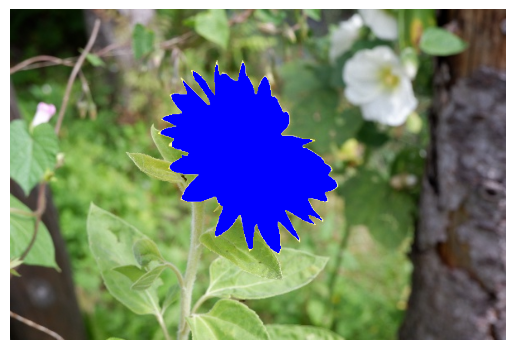

In [29]:
plt.imshow(image_rgb)
plot_mask(masks)
plt.axis("off")
plt.show()

In [33]:
box = widget.bboxes[0]
box = np.array([box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']])

In [34]:
masks, scores, logits = predictor.predict(box=box, multimask_output=True)

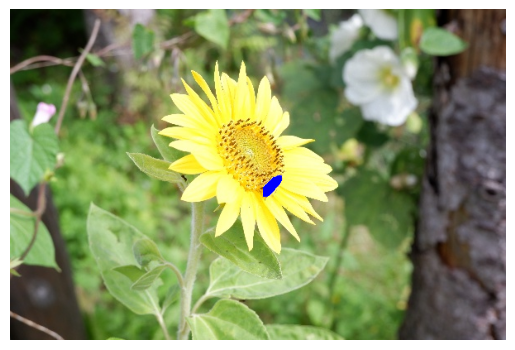

In [35]:
plt.imshow(image_rgb)
plot_mask(masks)
plt.axis("off")
plt.show()